# pipline for A Stage

A STAGE

SEER*Stat Name: SEER historic stage A

Field Description: Derived from Collaborative Stage (CS) for 2004+ and Extent of Disease (EOD) from 1973-2003. It is a simplified version of stage: in situ, localized, regional, distant, & unknown. Over time several different EOD schemes have been used. Thus caution should be used when doing trend analysis. For more information including sites and years for which it isn't calculated, see http://seer.cancer.gov/seerstat/variables/seer/lrd-stage.

1

Regional — A neoplasm that has extended 1) beyond the limits of the organ of origin
directly into surrounding organs or tissues; 2) into regional lymph nodes by way of the
lymphatic system; or 3) by a combination of extension and regional lymph nodes.

2

Distant — A neoplasm that has spread to parts of the body remote from the primary
tumor either by direct extension or by discontinuous metastasis (e.g., implantation or
seeding) to distant organs, issues, or via the lymphatic system to distant lymph nodes.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
# grid search k value for SMOTE oversampling for imbalanced classification
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import datasets, metrics, model_selection#, svm
import warnings

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, recall_score,precision_score

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from cancer_func import cancer_encode
from cancer_func import cancer_features_select
from cancer_func import cancer_encoder
from cancer_func import cancer_features_selector
from cancer_func import report, cross_validation_report
from cancer_func import cancer_encode_without_ms

In [3]:
from sklearn.ensemble import RandomForestClassifier

In [4]:
df = pd.read_csv('Breast_Cancer.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

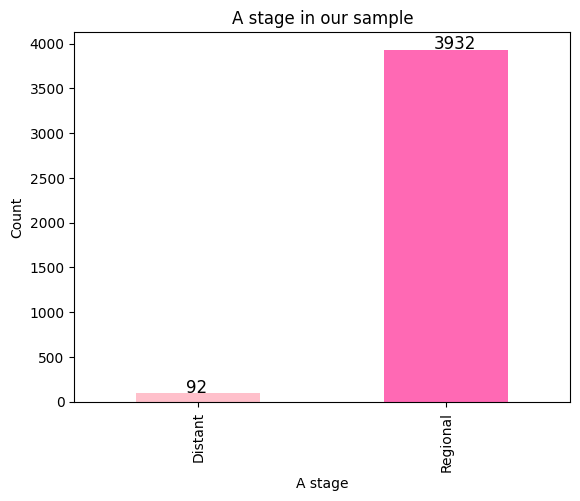

In [6]:
# Set the pinkish colors
colors = ['#FFC0CB', '#FF69B4', '#FF1493']  # Pinkish colors

# Group by 'Grade' and 'Race' and count the rows, specifying the desired order
grouped_df = df.groupby(['A Stage'])['Age'].count()

# Calculate the relative percentages within each grade
#relative_percentages = grouped_df.apply(lambda x: 100 * x / x.sum(), axis=1)


# Plot the unstacked bar graph
ax = grouped_df.plot.bar(color=colors)

# Set the style and labels for the plot
plt.rcParams['figure.figsize'] = (8, 5)  # Adjust the figure size as desired
plt.xlabel('A stage')
plt.ylabel('Count')
plt.title('A stage in our sample')

# Rotate the x-axis labels
#plt.xticks(rotation=45)
for index,data in enumerate(df.groupby(['A Stage'])['6th Stage'].count()):
    ax.text(x=index-0.05 , y =data+10 , s=f"{round(data)}" , fontdict=dict(fontsize=12))

plt.show()

# starting the pipline

In [7]:
def f_new(y_true, y_pred):
    precision = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    if recall >0.80:
        answer = 0.8+ f1_score(y_true, y_pred)
        return answer
    else:
        return recall


In [8]:
def f_new2(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    if recall >0.80:
        answer = recall+ f1
        return answer
    else:
        return recall


In [9]:
def f_new3(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    if recall >0.80:
        answer = recall+ precision
        return answer
    else:
        return recall


new pipline

In [10]:
df = pd.read_csv('Breast_Cancer.csv')
df = cancer_encode_without_ms(df)
#df = cancer_encode(df)
df = cancer_features_select(df)
X = df.drop(['A Stage'], axis=1, inplace=False) #sould be without  
y = df['A Stage']

In [11]:
over = SMOTE()
scaler = StandardScaler() #אני מנסה פה להשתמש בסקלר בלי לעטוף חזרה את הנתונים בטבלת פנדה. אם זה לא יעבוד נעטוף בפונקציה נפרדת
logistic = LogisticRegression(max_iter=100000) #צריך להגדיר את המודל 
#log_steps = [("encoder",encoder),("selector",selector),("scaler", scaler), ("over", over), ("logistic", logistic)]
log_steps = [("scaler", scaler), ("over", over), ("logistic", logistic)]

pipe_log = Pipeline(steps=log_steps)

param_grid_log = {
    "over__sampling_strategy": [0.1,0.2,0.3,0.5],
    "over__k_neighbors": [5,6,7,8],
    "logistic__C": [1,4],
    "logistic__class_weight":[{0: 1, 1: 1},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 10}]
}


In [12]:
search_new = GridSearchCV(pipe_log, param_grid_log, n_jobs=5,scoring=make_scorer(f_new))
search_new.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_new.best_score_)
print(search_new.best_params_)
log_estimator_new = search_new.best_estimator_

Best parameter (CV score=1.134):
{'logistic__C': 4, 'logistic__class_weight': {0: 1, 1: 3}, 'over__k_neighbors': 5, 'over__sampling_strategy': 0.1}


In [13]:
search_new2 = GridSearchCV(pipe_log, param_grid_log, n_jobs=5,scoring=make_scorer(f_new2))
search_new2.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_new2.best_score_)
print(search_new2.best_params_)
log_estimator_new2 = search_new2.best_estimator_
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores_log = cross_validate(log_estimator_new2, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores_log)

Best parameter (CV score=1.302):
{'logistic__C': 4, 'logistic__class_weight': {0: 1, 1: 3}, 'over__k_neighbors': 6, 'over__sampling_strategy': 0.5}
Mean f1:  0.298
Mean recall: 0.967
Mean precision: 0.176
cross_validation confusion matrix
     0       1
0  3516    416
1   3       89


In [14]:
search_new2 = GridSearchCV(pipe_log, param_grid_log, n_jobs=5,scoring=make_scorer(f_new3))
search_new2.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_new2.best_score_)
print(search_new2.best_params_)
log_estimator_new2 = search_new2.best_estimator_
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores_log = cross_validate(log_estimator_new2, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores_log)

Best parameter (CV score=1.177):
{'logistic__C': 4, 'logistic__class_weight': {0: 1, 1: 10}, 'over__k_neighbors': 5, 'over__sampling_strategy': 0.2}
Mean f1:  0.296
Mean recall: 0.978
Mean precision: 0.174
cross_validation confusion matrix
     0       1
0  3506    426
1   2       90


In [15]:
def cross_validation_report(df,binary_target,cv_scores):
    print('Mean f1:  %.3f' % mean(cv_scores['test_f1']))
    print('Mean recall: %.3f' % mean(cv_scores['test_recall']))
    print('Mean precision: %.3f' % mean(cv_scores['test_precision']))
    rec = mean(cv_scores['test_recall'])
    pre = mean(cv_scores['test_precision'])
    total_p = df.groupby([binary_target])[binary_target].count()[1]
    total_n = df.groupby([binary_target])[binary_target].count()[0]
    TP = rec*total_p
    FN = (1-rec)*total_p
    FP = ((1-pre)/pre)*TP
    TN = total_n - FP
    print("cross_validation confusion matrix")
    print("     0       1")
    print("0 ",round(TN), "  ", round(FP))
    print("1  ",round(FN), "     ", round(TP))

    
    

# evaluate pipeline


(0.0, 1.1)

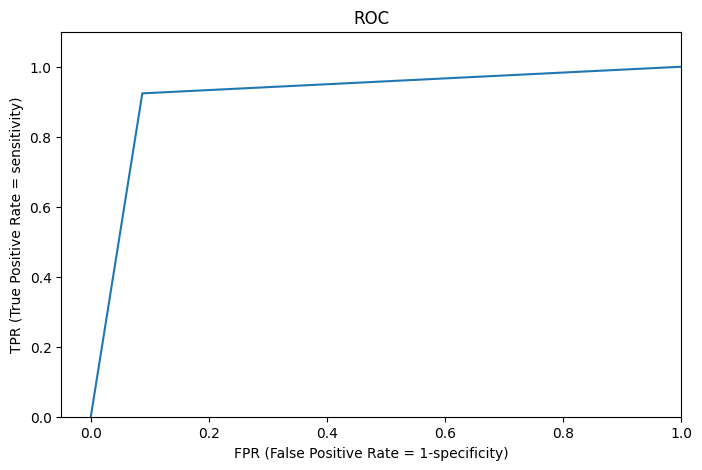

In [16]:
fpr, tpr, thresholds = roc_curve(y, log_estimator_new.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

# random forest

newes

In [17]:
rf = RandomForestClassifier()
over = SMOTE()
scaler = StandardScaler()

rf_steps = [("scaler", scaler), ("over", over), ("rf", rf)]
pipe_rf = Pipeline(steps=rf_steps)

param_grid_rf = {
    "over__sampling_strategy": [0.1,0.2,0.3,0.5],
    "over__k_neighbors": [5,6,7,8],
    "rf__max_depth": [3,4,5,6],
    "rf__min_samples_leaf": [4,5,6,10],
    "rf__class_weight":[{0: 1, 1: 1},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 10}]
}
search_rf = GridSearchCV(pipe_rf, param_grid_rf, n_jobs=5,scoring=make_scorer(f_new2))
search_rf.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_rf.best_score_)
print(search_rf.best_params_)
rf_estimator =search_rf.best_estimator_


Best parameter (CV score=1.299):
{'over__k_neighbors': 7, 'over__sampling_strategy': 0.3, 'rf__class_weight': {0: 1, 1: 1}, 'rf__max_depth': 3, 'rf__min_samples_leaf': 6}


In [18]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(rf_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores)

Mean f1:  0.287
Mean recall: 0.951
Mean precision: 0.169
cross_validation confusion matrix
     0       1
0  3503    429
1   4       88


(0.0, 1.1)

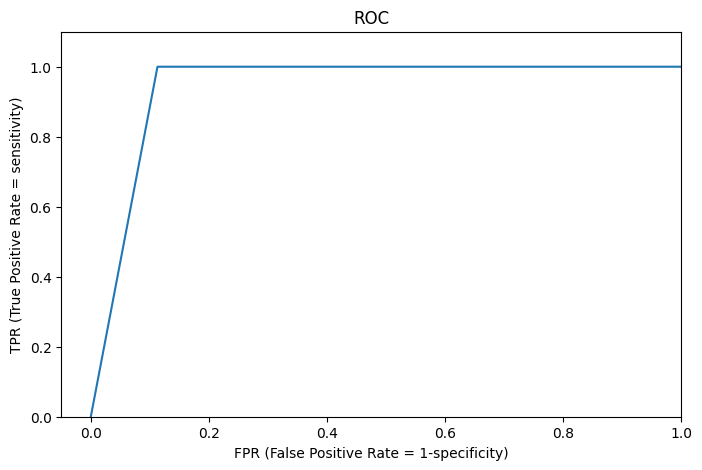

In [19]:
fpr, tpr, thresholds = roc_curve(y, rf_estimator.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

In [20]:
hd = list(X.columns)
print("feature importances: ")
for i, f in zip(hd, search_rf.best_estimator_.named_steps['rf'].feature_importances_):
     print(i,round(f*100,2))

feature importances: 
Age 0.15
T Stage  14.35
N Stage 18.42
6th Stage 27.65
Grade 0.77
Tumor Size 1.72
Estrogen Status 0.39
Progesterone Status 0.11
Regional Node Examined 1.07
Reginol Node Positive 7.4
Race_Black 0.25
Race_Other 0.03
Race_White 0.16
6th Stage_IIA 2.11
6th Stage_IIB 0.88
6th Stage_IIIA 1.79
6th Stage_IIIB 5.01
6th Stage_IIIC 11.52
Regional_Node_pos_% 6.1
Estrogen&Progesterone positive 0.1
Estrogen&Progesterone Negative 0.05


In [21]:
rf = RandomForestClassifier()
over = SMOTE()
scaler = StandardScaler()

rf_steps = [("scaler", scaler), ("over", over), ("rf", rf)]
pipe_rf = Pipeline(steps=rf_steps)

param_grid_rf = {
    "over__sampling_strategy": [0.1,0.2,0.3,0.5],
    "over__k_neighbors": [5,6,7,8],
    "rf__max_depth": [3,4,5,6],
    "rf__min_samples_leaf": [4,5,6,10],
    "rf__class_weight":[{0: 1, 1: 1},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 10}]
}
search_rf = GridSearchCV(pipe_rf, param_grid_rf, n_jobs=5,scoring=make_scorer(f_new3))
search_rf.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_rf.best_score_)
print(search_rf.best_params_)
rf_estimator =search_rf.best_estimator_
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(rf_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores)

Best parameter (CV score=1.176):
{'over__k_neighbors': 6, 'over__sampling_strategy': 0.1, 'rf__class_weight': {0: 1, 1: 3}, 'rf__max_depth': 3, 'rf__min_samples_leaf': 4}
Mean f1:  0.284
Mean recall: 0.946
Mean precision: 0.167
cross_validation confusion matrix
     0       1
0  3498    434
1   5       87


(0.0, 1.1)

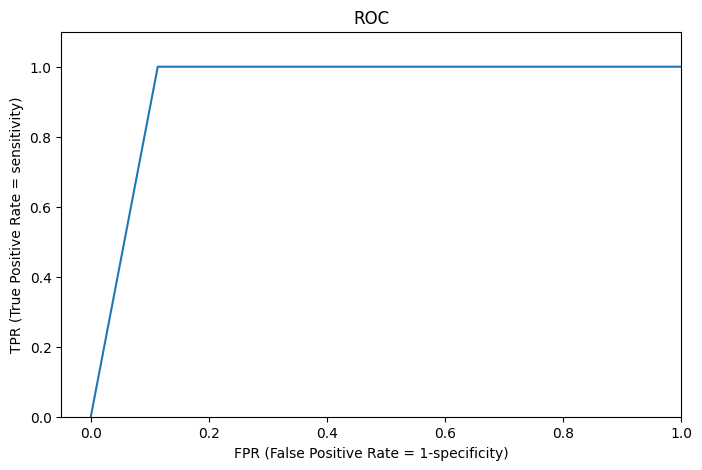

In [22]:
fpr, tpr, thresholds = roc_curve(y, rf_estimator.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

In [23]:
hd = list(X.columns)
print("feature importances: ")
for i, f in zip(hd, search_rf.best_estimator_.named_steps['rf'].feature_importances_):
     print(i,round(f*100,2))

feature importances: 
Age 0.33
T Stage  12.76
N Stage 15.35
6th Stage 24.3
Grade 0.52
Tumor Size 1.85
Estrogen Status 0.54
Progesterone Status 0.03
Regional Node Examined 0.86
Reginol Node Positive 9.69
Race_Black 0.03
Race_Other 0.04
Race_White 0.09
6th Stage_IIA 1.21
6th Stage_IIB 0.6
6th Stage_IIIA 2.05
6th Stage_IIIB 8.52
6th Stage_IIIC 18.4
Regional_Node_pos_% 2.46
Estrogen&Progesterone positive 0.33
Estrogen&Progesterone Negative 0.03


new

In [24]:
rf = RandomForestClassifier()
over = SMOTE()
scaler = StandardScaler()

rf_steps = [("scaler", scaler), ("over", over), ("rf", rf)]
pipe_rf = Pipeline(steps=rf_steps)

param_grid_rf = {
    "over__sampling_strategy": [0.1,0.2,0.3,0.5],
    "over__k_neighbors": [5,6,7,8],
    "rf__max_depth": [3,4,5,6],
    "rf__min_samples_leaf": [4,5,6,10],
    "rf__class_weight":[{0: 1, 1: 1},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 10}]
}



In [25]:
hd = list(X.columns)
print("feature importances: ")
for i, f in zip(hd, search_rf.best_estimator_.named_steps['rf'].feature_importances_):
     print(i,round(f*100,2))

feature importances: 
Age 0.33
T Stage  12.76
N Stage 15.35
6th Stage 24.3
Grade 0.52
Tumor Size 1.85
Estrogen Status 0.54
Progesterone Status 0.03
Regional Node Examined 0.86
Reginol Node Positive 9.69
Race_Black 0.03
Race_Other 0.04
Race_White 0.09
6th Stage_IIA 1.21
6th Stage_IIB 0.6
6th Stage_IIIA 2.05
6th Stage_IIIB 8.52
6th Stage_IIIC 18.4
Regional_Node_pos_% 2.46
Estrogen&Progesterone positive 0.33
Estrogen&Progesterone Negative 0.03


In [26]:
hd = list(X.columns)
print("feature importances: ")
for i, f in zip(hd, search_rf.best_estimator_.named_steps['rf'].feature_importances_):
     print(i,round(f*100,2))

feature importances: 
Age 0.33
T Stage  12.76
N Stage 15.35
6th Stage 24.3
Grade 0.52
Tumor Size 1.85
Estrogen Status 0.54
Progesterone Status 0.03
Regional Node Examined 0.86
Reginol Node Positive 9.69
Race_Black 0.03
Race_Other 0.04
Race_White 0.09
6th Stage_IIA 1.21
6th Stage_IIB 0.6
6th Stage_IIIA 2.05
6th Stage_IIIB 8.52
6th Stage_IIIC 18.4
Regional_Node_pos_% 2.46
Estrogen&Progesterone positive 0.33
Estrogen&Progesterone Negative 0.03


# xgboost

In [27]:
# !pip install xgboost

In [28]:
!pip install lightgbm

zsh:1: command not found: pip


In [29]:

# check xgboost version
import xgboost
import lightgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
XGB = XGBClassifier(n_estimators=700)
over = SMOTE()
scaler = StandardScaler() #אני מנסה פה להשתמש בסקלר בלי לעטוף חזרה את הנתונים בטבלת פנדה. אם זה לא יעבוד נעטוף בפונקציה נפרדת
XGB_steps = [("scaler", scaler), ("over", over), ("XGB", XGB)]
pipe_XGB= Pipeline(steps=XGB_steps)

param_grid_XGB = {
    "over__sampling_strategy": [0.4,0.5],
    "over__k_neighbors": [7,9],
    "XGB__max_depth": [3,4],
    "XGB__scale_pos_weight": [5,10,50,80],
    #'XGB__subsample': [1.0],
    #"XGB__colsample_bytree": [1.0],
    "XGB__gamma":[ 2,3,5],
    "XGB__learning_rate":[0.05,0.1,0.01],
}

In [ ]:
XGB_search = GridSearchCV(pipe_XGB, param_grid_XGB, n_jobs=4,scoring=make_scorer(f_new))
XGB_search.fit(X, y)
XGB_estimator =XGB_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % XGB_search.best_score_)
print(XGB_search.best_params_)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(XGB_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))


In [ ]:
print(report(XGB_search, X, y))

In [ ]:
XGB_search = GridSearchCV(pipe_XGB, param_grid_XGB, n_jobs=4,scoring=make_scorer(f_new2))
XGB_search.fit(X, y)
XGB_estimator =XGB_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % XGB_search.best_score_)
print(XGB_search.best_params_)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(XGB_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))


In [ ]:
print(report(XGB_search, X, y))

In [ ]:
XGB_search = GridSearchCV(pipe_XGB, param_grid_XGB, n_jobs=4,scoring=make_scorer(f_new))
XGB_search.fit(X, y)
XGB_estimator =XGB_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % XGB_search.best_score_)
print(XGB_search.best_params_)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(XGB_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))


In [ ]:
fpr, tpr, thresholds = roc_curve(y, XGB_estimator.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

In [ ]:
XGB = XGBClassifier(n_estimators=700)
over = SMOTE()
scaler = StandardScaler() #אני מנסה פה להשתמש בסקלר בלי לעטוף חזרה את הנתונים בטבלת פנדה. אם זה לא יעבוד נעטוף בפונקציה נפרדת
XGB_steps = [("scaler", scaler), ("over", over), ("XGB", XGB)]
pipe_XGB= Pipeline(steps=XGB_steps)

param_grid_XGB = {
    "over__sampling_strategy": [0.4,0.5,0.6],
    "over__k_neighbors": [7,9],
    "XGB__max_depth": [3,4,5],
    "XGB__scale_pos_weight": [10,50,80,90],
    'XGB__subsample': [0.8,1.0],
    "XGB__colsample_bytree": [0.8,1.0],
    "XGB__gamma":[ 2,3,5],
    "XGB__learning_rate":[0.05,0.01]
}

In [ ]:
XGB_search = GridSearchCV(pipe_XGB, param_grid_XGB, n_jobs=4,scoring=make_scorer(f_new2))
XGB_search.fit(X, y)
XGB_estimator =XGB_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % XGB_search.best_score_)
print(XGB_search.best_params_)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(XGB_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))


In [ ]:
fpr, tpr, thresholds = roc_curve(y, XGB_estimator.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

# lgbm

newer

In [ ]:
LGBM = LGBMClassifier(learning_rate=0.01)
LGBM_steps = [("scaler", scaler), ("over", over), ("LGBM", LGBM)]
pipe_LGBM = Pipeline(steps=LGBM_steps)

param_grid_LGBM = {
    "over__sampling_strategy": [0.1,0.2,0.3,0.4,0.5],
    "over__k_neighbors": [6,7,8],
    "LGBM__max_depth": [3,4,6,7,8],
    "LGBM__class_weight":[{0: 1, 1: 10},{0: 1, 1: 15},{0: 1, 1: 3},{0: 1, 1: 5},{0: 1, 1: 6}],
     "LGBM__lambda_l1":[0,1,2]
}
LGBM_search = GridSearchCV(pipe_LGBM, param_grid_LGBM, n_jobs=5,scoring=make_scorer(f_new2))
LGBM_search.fit(X, y)
LGBM_estimator =LGBM_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % LGBM_search.best_score_)
print(LGBM_search.best_params_)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(LGBM_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores)

In [ ]:
hd = list(X.columns)
print("feature importances: ")
for i, f in zip(hd, LGBM_search.best_estimator_.named_steps['LGBM'].feature_importances_):
     print(i,round(f,2))

new

In [ ]:
LGBM = LGBMClassifier()
LGBM_steps = [("scaler", scaler), ("over", over), ("LGBM", LGBM)]
pipe_LGBM = Pipeline(steps=LGBM_steps)

param_grid_LGBM = {
    "over__sampling_strategy": [0.1,0.2,0.3],
    "over__k_neighbors": [6,7,8],
    "LGBM__max_depth": [3,4,6,7,8],
    "LGBM__learning_rate":[0.05,0.1,0.01],
    "LGBM__class_weight":[{0: 1, 1: 10},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 5},{0: 1, 1: 6}],
     "LGBM__lambda_l1":[0,1]
}

In [ ]:
LGBM_search = GridSearchCV(pipe_LGBM, param_grid_LGBM, n_jobs=5,scoring=make_scorer(f_new))
LGBM_search.fit(X, y)
LGBM_estimator =LGBM_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % LGBM_search.best_score_)
print(LGBM_search.best_params_)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(LGBM_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))


In [ ]:
hd = list(X.columns)
print("feature importances: ")
for i, f in zip(hd, LGBM_search_recall.best_estimator_.named_steps['LGBM'].feature_importances_):
     print(i,round(f,2))